#### 1. Setup packages and paths


In [2]:
%load_ext autoreload
%autoreload 2
import torch
from scipy.io import loadmat
import numpy as np
annot_path = "./data/annotation/annot_all.mat"
behav_feature_path = "./data/tracking/bvSet.mat"
dlx_raw_track_folder = "./data/tracking/DLX-DLX"
cmk_raw_track_folder = "./data/tracking/CMK-CMK"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2. Load data and save as numpy npz


In [3]:
annot_all = loadmat(annot_path)
dlx_annot = annot_all["annot_all"][0][0][0]
cmk_annot = annot_all["annot_all"][0][0][1]
np.savez_compressed("./data/annotation/annot.npz", dlx=dlx_annot, cmk=cmk_annot)
behav_features = loadmat(
    behav_feature_path,
)[
    "bvSet"
][0, 0]
# 75 individual behavioral features and 25 relational features
dlx_feature = behav_features[0]
cmk_feature = behav_features[1]
np.savez_compressed("./data/tracking/feature.npz", dlx=dlx_feature, cmk=cmk_feature)

print("make sure annotation and feature have same shape!")
print(f"row = pairs, col = animal dlx annotation {dlx_annot.shape}")
print(f"row = pairs, col = animal dlx feature {dlx_feature.shape}")
print(f"row = pairs, col = animal cmk annotation {dlx_annot.shape}")
print(f"row = pairs, col = animal cmk feature {dlx_feature.shape}")

make sure annotation and feature have same shape!
row = pairs, col = animal dlx annotation (10, 2)
row = pairs, col = animal dlx feature (10, 2)
row = pairs, col = animal cmk annotation (10, 2)
row = pairs, col = animal cmk feature (10, 2)


#### 3. Validate the dataset


In [4]:
num_features = 100  # 25 relational and 75 individual
annot = np.load("./data/annotation/annot.npz", allow_pickle=True)
dlx_annot = annot["dlx"].flatten()
cmk_annot = annot["cmk"].flatten()
feature = np.load("./data/tracking/feature.npz", allow_pickle=True)
dlx_feature = feature["dlx"].flatten()
cmk_feature = feature["cmk"].flatten()
for ft, at in zip(
    np.concatenate((dlx_feature, cmk_feature)), np.concatenate(([dlx_annot, cmk_annot]))
):
    assert (
        ft.shape[0] == at.shape[0]
    ), "The length of features and annot should be the same"
    assert (
        ft.shape[1] == num_features
    ), f"The number of features should be {num_features}"
    assert at.shape[1] == 1, "Dim of annotation should be 1"

#### 4. Basic characterization and visualization of the dataset


In [6]:
"""
Create the dataset. col 0-2 id, pairid, animalid, 
col 3 annot, col 4-103 features (4-78 individual,
79-103 relational)
"""

import pandas as pd

all_feat = np.concatenate((dlx_feature, cmk_feature))
all_annot = np.concatenate((dlx_annot, cmk_annot))
feat_names = pd.read_csv("./data/tracking/bvfeat_names.csv", header=None)
col_names = pd.concat(
    (
        pd.Series("id"),
        pd.Series("pairid"),
        pd.Series("anid"),
        pd.Series("annot"),
        feat_names,
    ),
    ignore_index=True,
    axis=1,
)

dataset = pd.DataFrame(columns=col_names.iloc[0])
pairid = 1
anid = 1
for idx, (annt, feat) in enumerate(zip(all_annot, all_feat)):
    pairid = idx // 2
    anid = idx % 2
    idx_array = np.empty((annt.shape[0], 3))
    idx_array[:, 0:3] = [idx, pairid, anid]
    data = np.concatenate((idx_array, annt, feat), axis=1)
    data_df = pd.DataFrame(data, columns=col_names.iloc[0])
    dataset = pd.concat((dataset, data_df), axis=0)

/var/folders/b3/kd4d5cfd381bbjfswjtqnkz00000gn/T/ipykernel_17733/3805660766.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat((dataset, data_df), axis=0)


Text(0.5, 1.0, 'transition matrix with self transition suppressed')

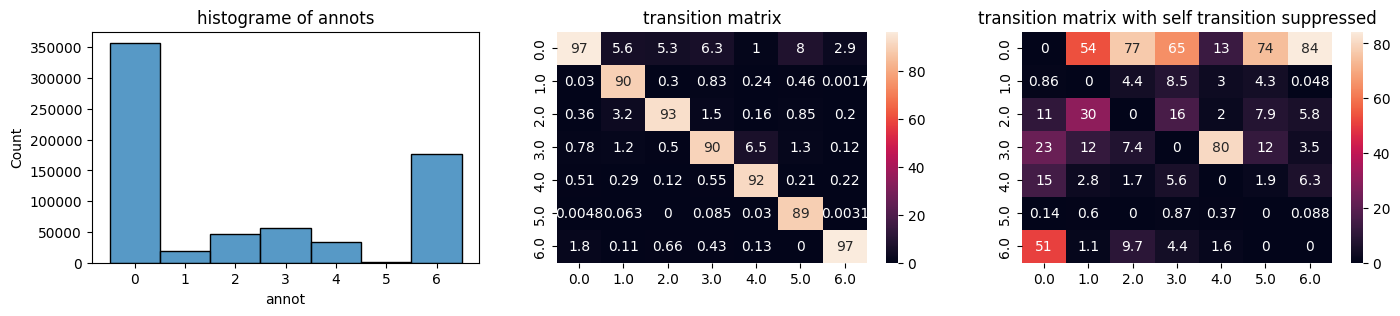

In [7]:
"""
Annotation distribution, transition probability, etc.
"""

from matplotlib import pyplot
import seaborn as ses
from util import *

fig, axes = pyplot.subplots(1, 3, figsize=(17, 3))
ses.histplot(dataset["annot"], bins=np.arange(8) - 0.5, ax=axes[0])
trans_mat = transition_mat(dataset, "annot", 1, "id", 0)
ses.heatmap(trans_mat * 100, ax=axes[1], annot=True)
for i in range(trans_mat.shape[0]):
    trans_mat.iloc[i, i] = 0
ses.heatmap(trans_mat / trans_mat.sum(axis=0) * 100, ax=axes[2], annot=True)
axes[0].set_title("histograme of annots")
axes[1].set_title("transition matrix")
axes[2].set_title("transition matrix with self transition suppressed")

Text(0.5, 1.0, 'mean bout length')

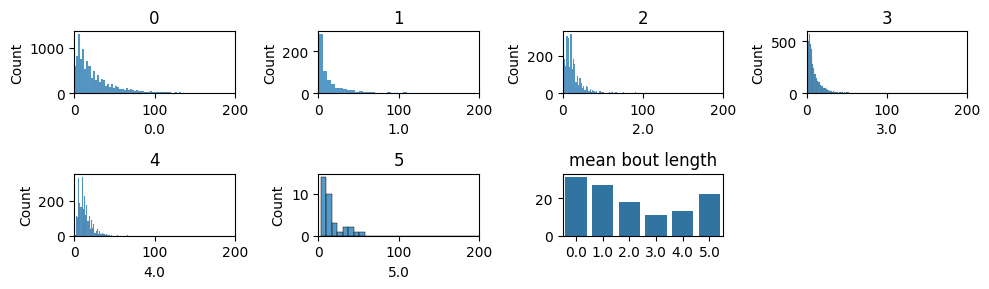

In [9]:
"""
Continuous bout length etc.
"""

bout_lengths = count_continous_bouts(dataset)
bout_lengths = bout_lengths[np.arange(6)]
fig, axes = pyplot.subplots(2, 4, figsize=(10, 3))
for idx in range(6):
    ses.histplot(bout_lengths[idx], ax=axes[idx // 4, idx % 4])
    axes[idx // 4, idx % 4].set_xlim([0, 200])
    axes[idx // 4, idx % 4].set_title(str(idx))
axes[1, 3].remove()
ses.barplot(bout_lengths.mean(axis=0), ax=axes[1, 2])
fig.tight_layout()
axes[1, 2].set_title("mean bout length")

/var/folders/b3/kd4d5cfd381bbjfswjtqnkz00000gn/T/ipykernel_16789/3565014130.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bplot.set_xticklabels(
/var/folders/b3/kd4d5cfd381bbjfswjtqnkz00000gn/T/ipykernel_16789/3565014130.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bplot.set_xticklabels(
/var/folders/b3/kd4d5cfd381bbjfswjtqnkz00000gn/T/ipykernel_16789/3565014130.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bplot.set_xticklabels(


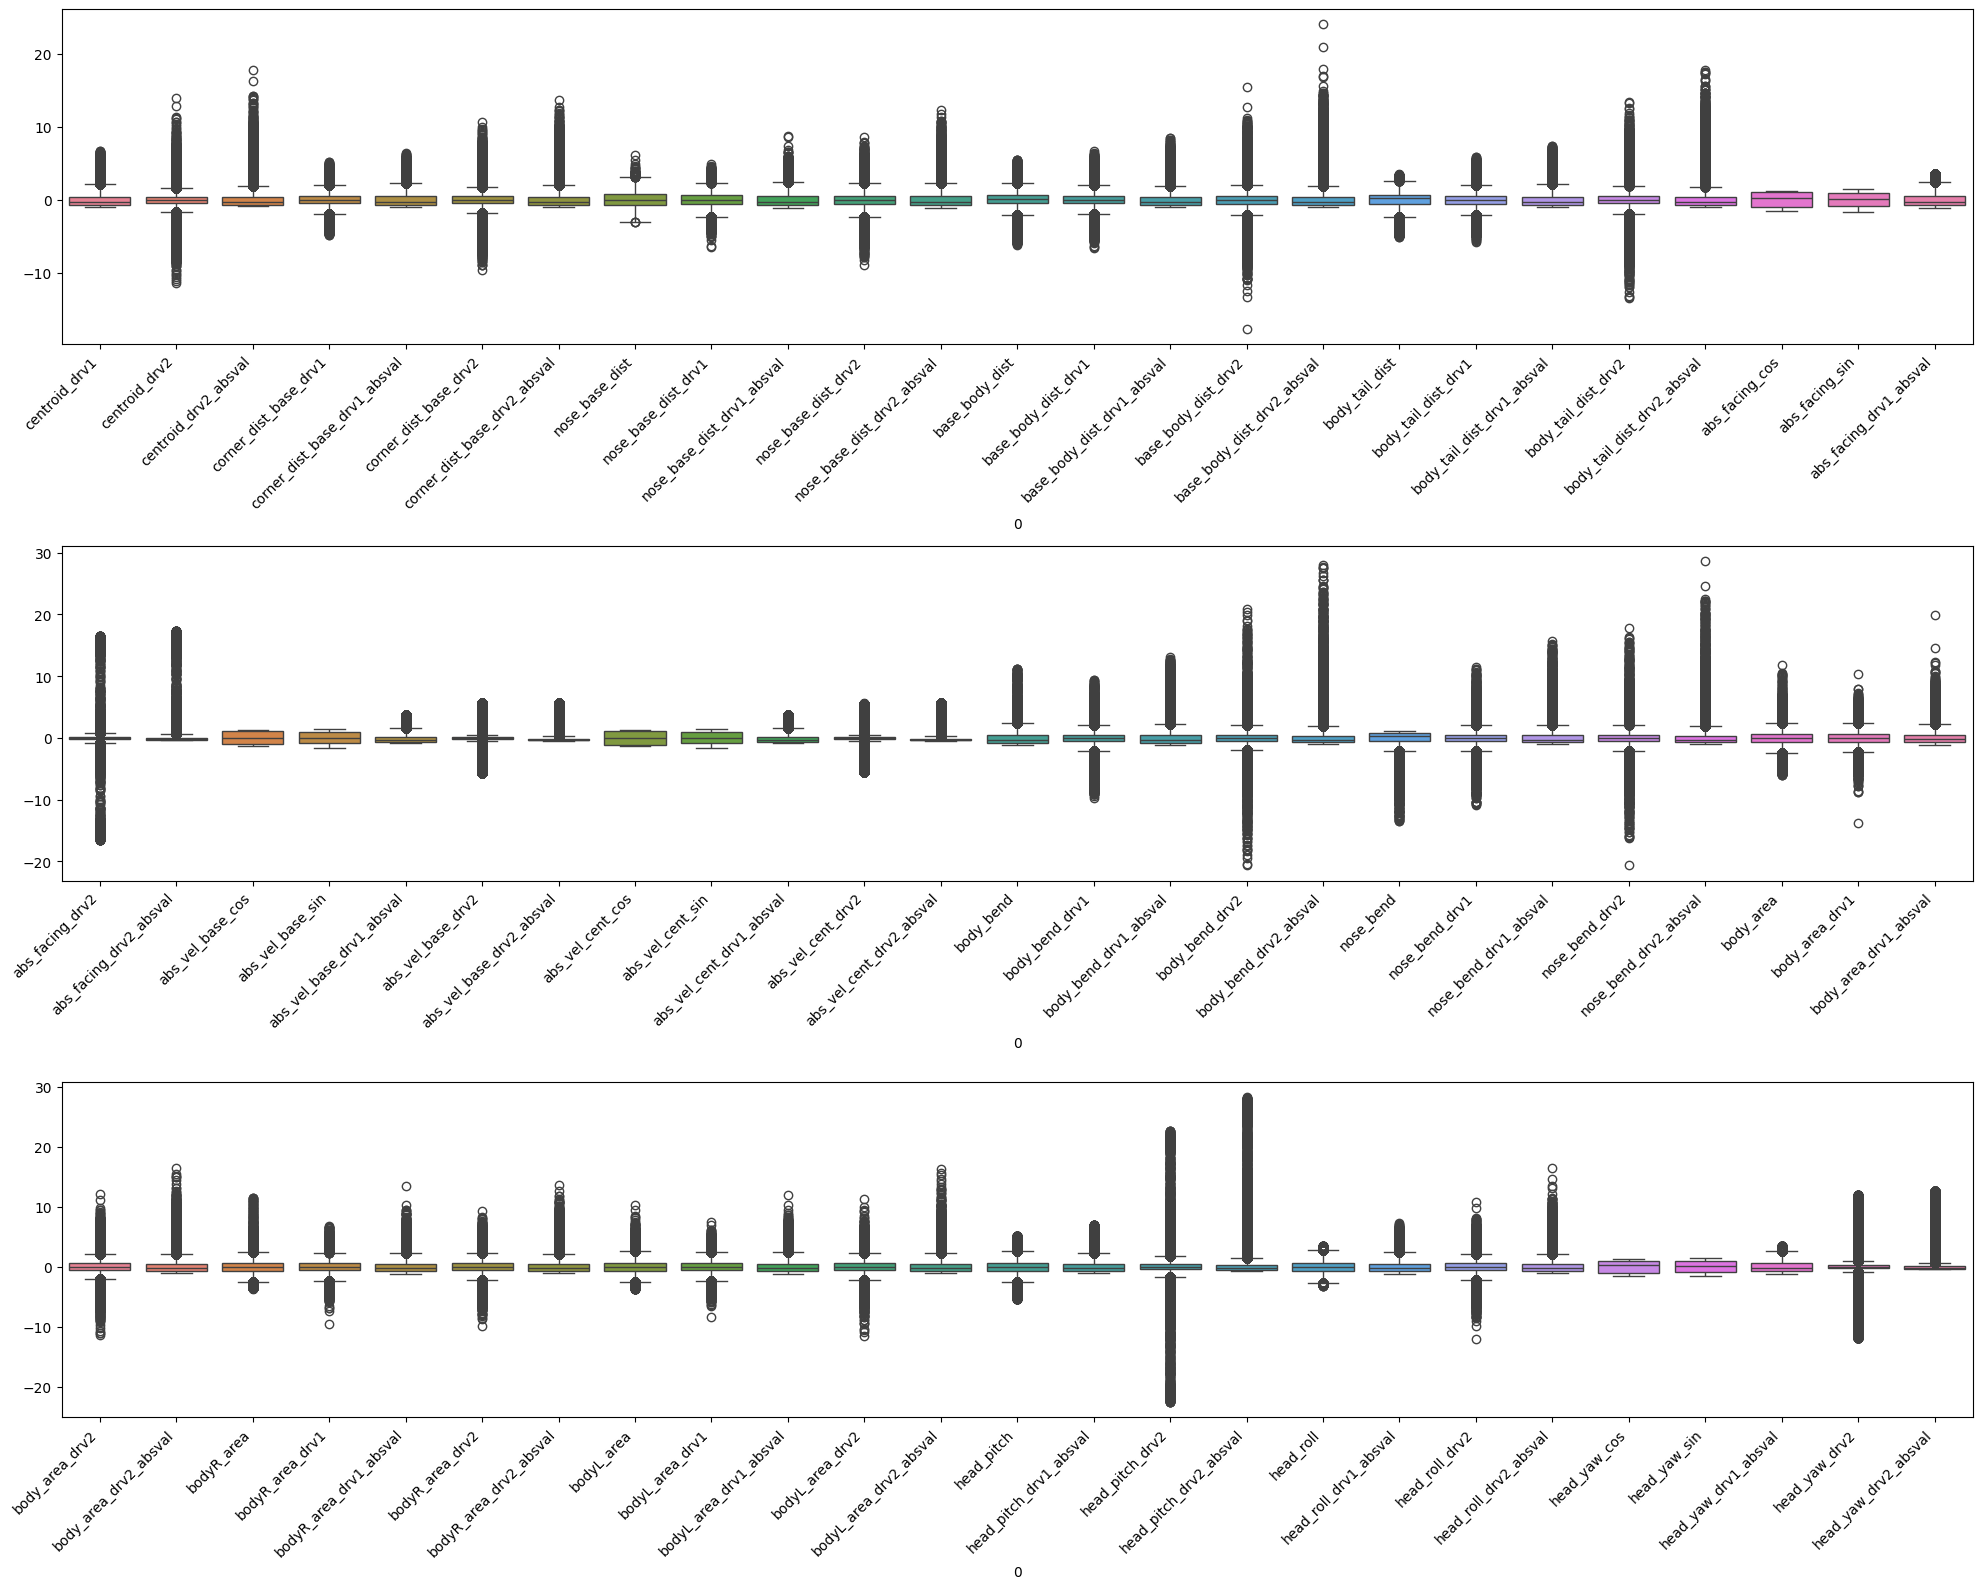

In [35]:
"""
Character individual features
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(dataset.iloc[:, 4:])
dataset.iloc[:, 4:] = scaler.transform(dataset.iloc[:, 4:])
fig, axes = pyplot.subplots(3, 1, figsize=(20, 16))
for i in np.arange(3):
    ax = axes[i % 3]
    bplot = ses.boxplot(dataset.iloc[:, (4 + i * 25) : (29 + i * 25)], ax=ax)
    bplot.set_xticklabels(
        bplot.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
fig.tight_layout()

/var/folders/b3/kd4d5cfd381bbjfswjtqnkz00000gn/T/ipykernel_16789/489384485.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment="right")


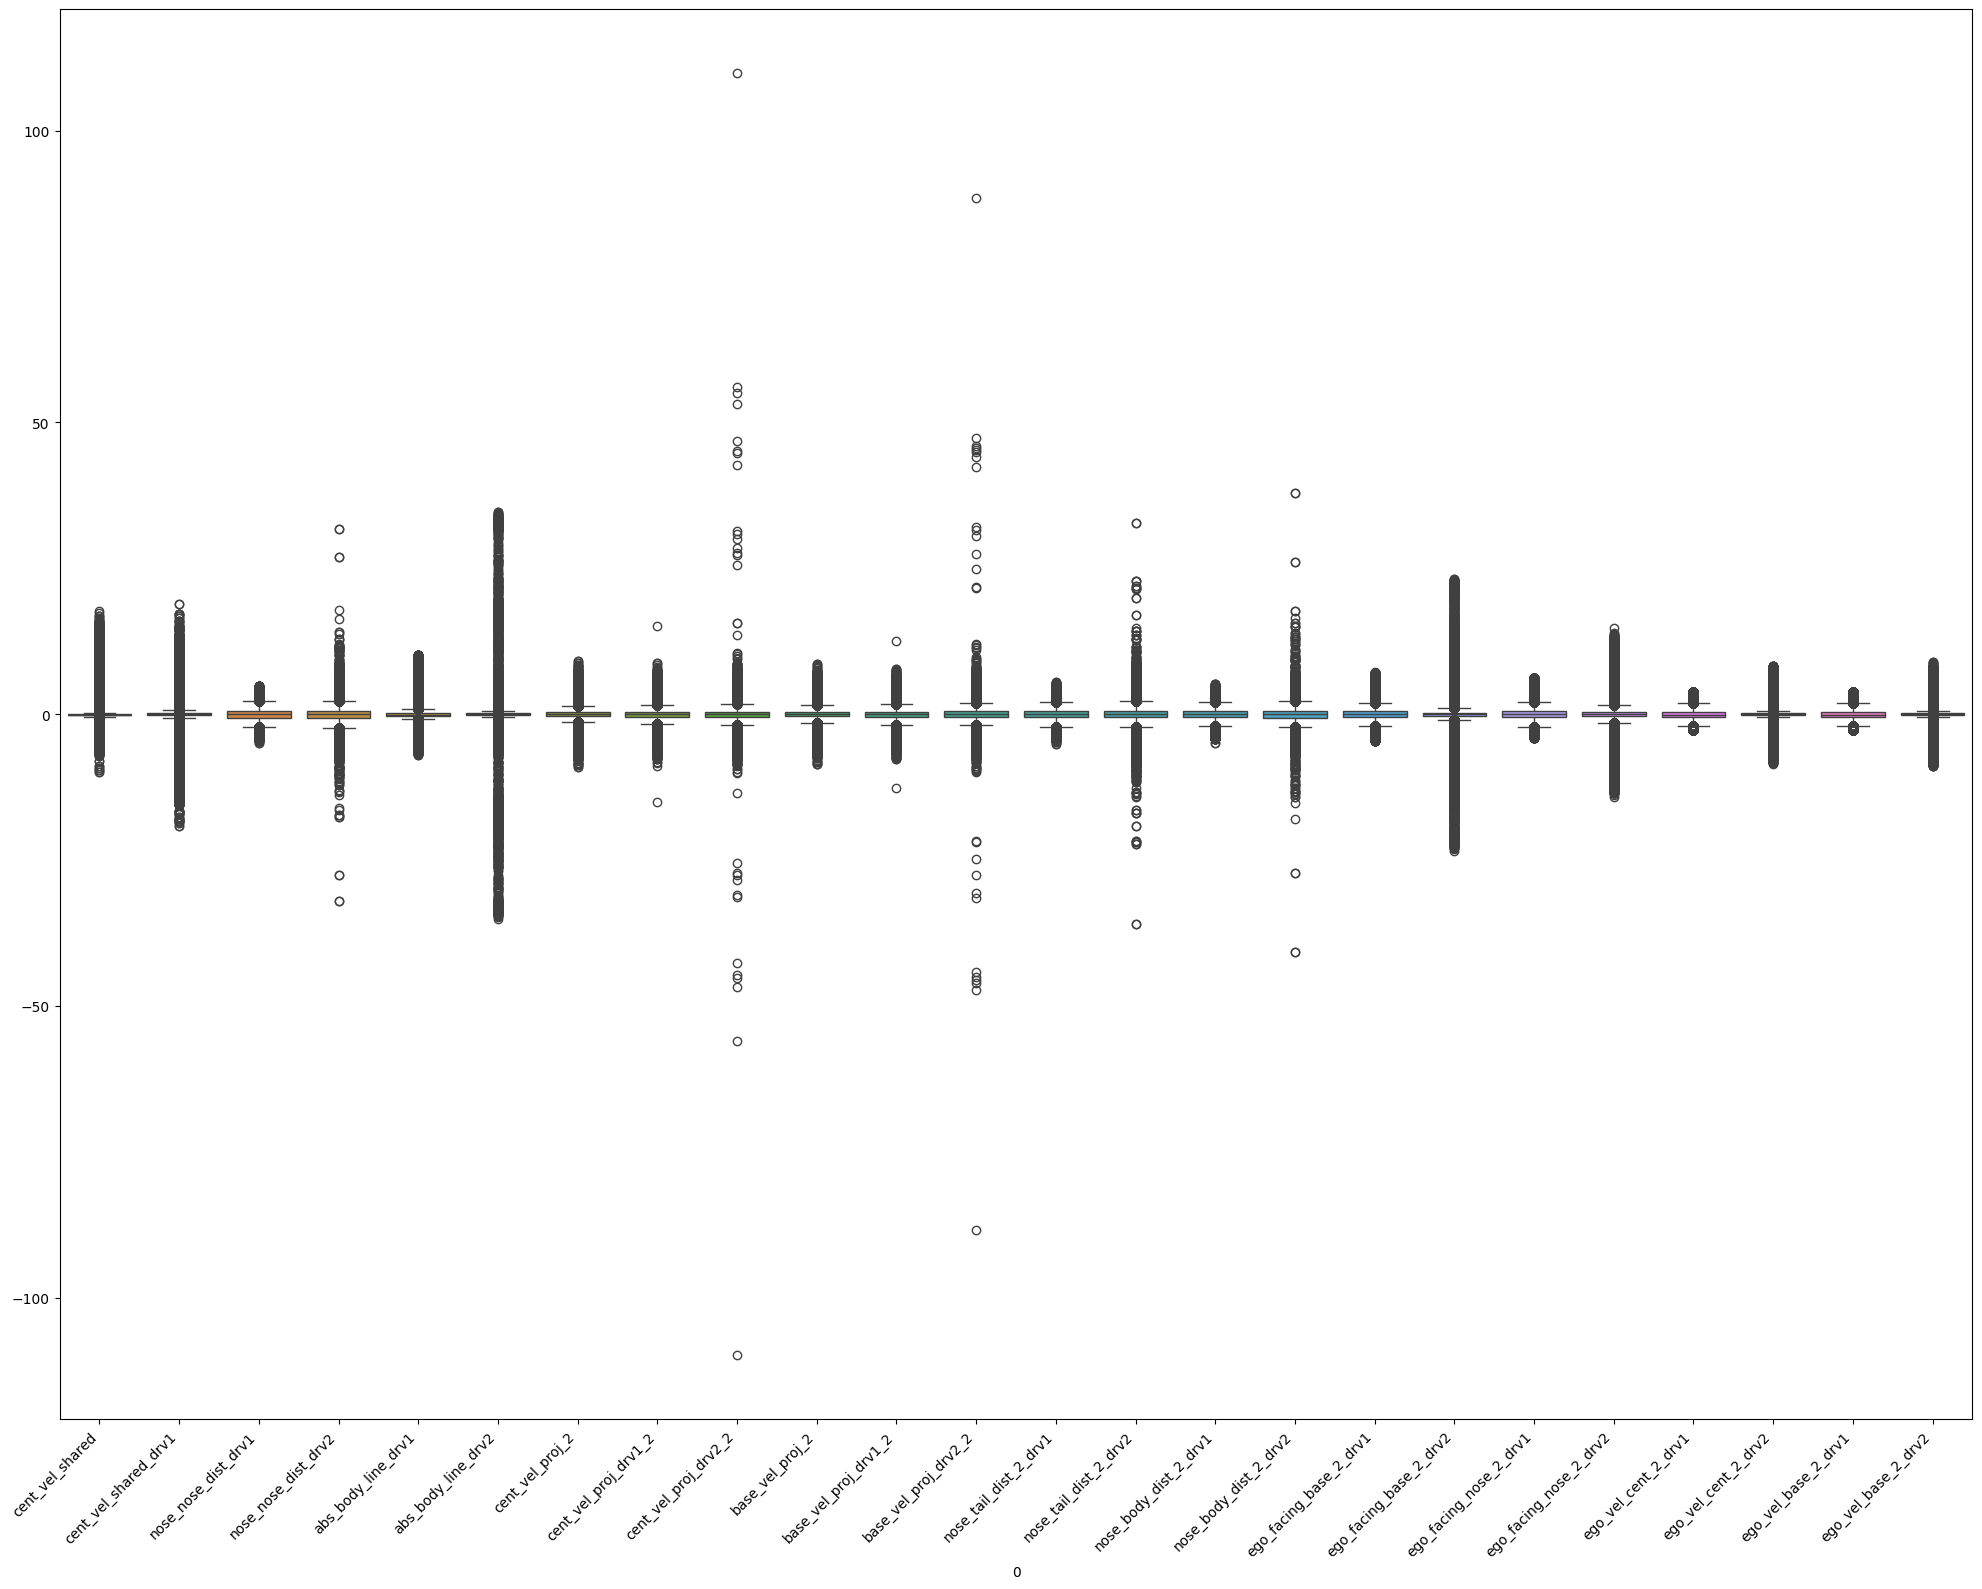

In [36]:
"""
Character individual features
"""
fig, axes = pyplot.subplots(1, 1, figsize=(20, 16))
bplot = ses.boxplot(dataset.iloc[:, 79:104], ax=axes)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment="right")
fig.tight_layout()

In [10]:
covmat = dataset.iloc[:, 4:].cov()
ses.heatmap(covmat)

: 

#### 4. Create track2annot model, pass a dummy dataset to validate model works


In [ ]:
# Feed dummy data into pose model for sanity check
from poseModel import *

model = PoseModel(input_size=12, hidden_size=24, behav_class=5, dropout_rate=0.2)
model.train()

dummy_train = np.random.randn(9, 20, 12)
dummy_label = np.random.randint(low=0, high=5, size=(9, 20))
dummy_out = model(dummy_train, dummy_label)
print(dummy_out)

In [ ]:
# Feed dummy data to test beam search
complete_hypo = model.beam_search(dummy_train[1:2])
print(complete_hypo)

In [ ]:
from util import prepare_dataset

dataset = prepare_dataset("./data", 15)

In [ ]:
print(dataset[100][0].shape)

In [ ]:
generator2 = torch.Generator().manual_seed(42)
traindata, valdata = torch.utils.data.random_split(dataset, (0.7, 0.3), generator2)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(traindata, shuffle=True)